In [1]:
def load_AER(filename, check_sorted = False, relative_time = True):
    '''
    Loads AER data files for use in Brian.
    Returns a list containing tuples with a vector of addresses and a vector of timestamps (ints, unit is usually usecond).
    It can load any kind of .dat, or .aedat files.
    Note: For index files (that point to multiple .(ae)dat files) it will return a list containing tuples as for single files.
    
    Keyword Arguments:
    If check_sorted is True, checks if timestamps are sorted,
    and sort them if necessary.
    If relative_time is True, it will set the first spike time to zero and all others relatively to that precise time (avoid negative timestamps, is definitely a good idea).
    
    Hence to use those data files in Brian, one should do:
    addr, timestamp =  load_AER(filename, relative_time = True)
    G = AERSpikeGeneratorGroup((addr, timestamps))
    '''
    l = filename.split('.')
    ext = l[-1].strip('\n')
    filename = filename.strip('\n')
    directory = os.path.dirname(filename)
    if ext == 'aeidx':
        #AER data points to different AER files
        return load_multiple_AER(filename, check_sorted = check_sorted, relative_time = relative_time, directory = directory)
    elif not (ext == 'dat' or ext == 'aedat'):
        raise ValueError('Wrong extension for AER data, should be dat, or aedat, it was '+ext)
    
    # This is inspired by the following Matlab script:
    # http://jaer.svn.sourceforge.net/viewvc/jaer/trunk/host/matlab/loadaerdat.m?revision=2001&content-type=text%2Fplain
    f=open(filename,'rb')
    version=1 # default (if not found in the file)
    
    # Skip header and look for version number
    line = f.readline().decode('UTF-8')
    while line[0] == '#':
        if line[:9] == "#!AER-DAT":
            version = int(float(line[9:-1]))
        line = f.readline().decode('UTF-8') 
        if line[:9] == '# created':
            break
    line = f.read()
    f.close()
    
    
    if version==1:
        print ('Loading version 1 file '+filename)
        '''
        Format is: sequence of (addr = 2 bytes,timestamp = 4 bytes)
        Number format is big endian ('>')
        '''
        ## This commented paragraph is the non-vectorized version
        #nevents=len(line)/6
        #for n in range(nevents):
        #    events.append(unpack('>HI',line[n*6:(n+1)*6])) # address,timestamp
        x=fromstring(line, dtype=int16) # or uint16?
        x=x.reshape((len(x)/3,3))
        addr=x[:,0].newbyteorder('>')
        timestamp=x[:,1:].copy()
        timestamp.dtype=int32
        timestamp=timestamp.newbyteorder('>').flatten()
    else: # version==2
        print ('Loading version 2 file '+filename)
        '''
        Format is: sequence of (addr = 4 bytes,timestamp = 4 bytes)
        Number format is big endian ('>')
        '''
        ## This commented paragraph is the non-vectorized version
        #nevents=len(line)/8
        #for n in range(nevents):
        #    events.append(unpack('>II',line[n*8:(n+1)*8])) # address,timestamp
        x = np.frombuffer(line, dtype='int32').newbyteorder('>')
        addr = x[::2]
        if len(addr) == len(x[1::2]):
            timestamp = x[1::2]
        else:
            print ("""It seems there was a problem with the AER file, timestamps and addr don't have the same length!""")
            timestamp = x[1::2]

    if check_sorted: # Sorts the events if necessary
        if any(diff(timestamp)<0): # not sorted
            ind = argsort(timestamp)
            addr,timestamp = addr[ind],timestamp[ind]
    if (timestamp<0).all():
        print ('Negative timestamps')
    
    if relative_time:
        t0 = min(timestamp)
        timestamp -= t0
    
    return addr,timestamp

In [2]:
def extract_DVS_event(addr):
    '''
    Extracts retina event from an address or a vector of addresses.
    
    Chip: Digital Vision Sensor (DVS)
    http://siliconretina.ini.uzh.ch/wiki/index.php
    
    Returns: x, y, polarity (ON/OFF: 1/-1)
    '''
    retina_size=128

    xmask = 0xfE # x are 7 bits (64 cols) ranging from bit 1-8
    ymask = 0x7f00 # y are also 7 bits
    xshift=1 # bits to shift x to right
    yshift=8 # bits to shift y to right
    polmask=1 # polarity bit is LSB

    x = retina_size - 1 - ((addr & xmask) >> xshift)
    y = (addr & ymask) >> yshift
    pol = 1 - 2*(addr & polmask) # 1 for ON, -1 for OFF
    return x,y,pol

In [3]:
events_file_name = r"data\grabbed_data0\scale16\mnist_0_scale16_0001.aedat"

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation
import os


In [5]:
addr,timestamp = load_AER(events_file_name, relative_time = False)

Loading version 2 file data\grabbed_data0\scale16\mnist_0_scale16_0001.aedat


In [6]:
x,y,pol = extract_DVS_event(addr)

In [7]:
def set_offsets(I, T, dt = 1000):
    # Convert times into integers
    T = np.array(T/dt, dtype=int)
    # Put them into order
    # We use a field array to sort first by time and then by neuron index
    spikes = np.zeros(len(I), dtype=[('t', int), ('i', int)])
    spikes['t'] = T
    spikes['i'] = I
    spikes.sort(order=('t', 'i'))
    T = spikes['t']
    I = spikes['i']
        # Now for each timestep, we find the corresponding segment of I with
        # the spike indices for that timestep.
        # The idea of offsets is that the segment offsets[t]:offsets[t+1]
        # should give the spikes with time t, i.e. T[offsets[t]:offsets[t+1]]
        # should all be equal to t, and so then later we can return
        # I[offsets[t]:offsets[t+1]] at time t. It might take a bit of thinking
        # to see why this works. Since T is sorted, and bincount[i] returns the
        # number of elements of T equal to i, then j=cumsum(bincount(T))[t]
        # gives the first index in T where T[j]=t.
    offsets = np.hstack((0, np.cumsum(np.bincount(T))))
    return offsets

In [8]:
# the height and width of the DVS sensor
dvs_height = 128
dvs_width = 128

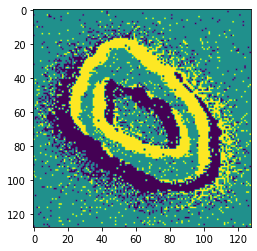

In [9]:
frame_img = np.zeros((dvs_height, dvs_width))
frame_img[y, x] = pol

img = plt.imshow(frame_img, vmin=-1, vmax=1, animated=True)

In [12]:
dt = 20e3
offset = set_offsets(addr, timestamp, dt)
# t = offset[-1]
# t = int(round(t/dt))

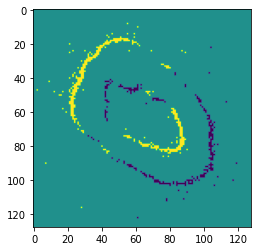

In [13]:
fig = plt.figure()
imgs = []
# nad tym zakresem t trzeba pomyśleć jaki ma być
for t in range(len(offset)-1):
    if t+1>=len(offset):
        ad = np.array([], dtype=int)
    ad = addr[offset[t]:offset[t+1]]
    x,y,pol = extract_DVS_event(ad)
    
    frame_img = np.zeros((dvs_height, dvs_width))
    frame_img[y, x] = pol

    img = plt.imshow(frame_img, vmin=-1, vmax=1, animated=True)
    imgs.append([img])

In [15]:
ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_html5_video())

In [16]:
import nengo
import nengo_loihi

In [18]:
t_length = len(offset)-1

In [19]:
# dvs_process otryzmuje złe parametry, plik events_file_name jest źle odczytywany
# może odczyt tak jak wyżej i zapis do pliku i dopiero wtedy ta funkcja 

pool = (1, 1)
gain = 101

with nengo.Network() as net:
    dvs_process = nengo_loihi.dvs.DVSFileChipProcess(
        file_path=events_file_name, pool=pool, channels_last=True
    )
    u = nengo.Node(dvs_process)

    ensembles = [
        nengo.Ensemble(
            dvs_process.height * dvs_process.width,
            1,
            neuron_type=nengo.SpikingRectifiedLinear(),
            gain=nengo.dists.Choice([gain]),
            bias=nengo.dists.Choice([0]),
        )
        for _ in range(dvs_process.polarity)
    ]

    for k, e in enumerate(ensembles):
        u_channel = u[k :: dvs_process.polarity]
        nengo.Connection(u_channel, e.neurons, transform=1.0 / np.prod(pool))

    probes = [nengo.Probe(e.neurons) for e in ensembles]

with nengo_loihi.Simulator(net) as sim:
    sim.run(t_length)

sim_t = sim.trange()
shape = (len(sim_t), dvs_process.height, dvs_process.width)
output_spikes_neg = sim.data[probes[0]].reshape(shape) * sim.dt
output_spikes_pos = sim.data[probes[1]].reshape(shape) * sim.dt

In [23]:
dt_frame = 0.01
t_frames = dt_frame * np.arange(int(round(t_length / dt_frame)))

array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1997e+02, 1.1998e+02,
       1.1999e+02])

In [27]:
sim_t

array([1.00000e-03, 2.00000e-03, 3.00000e-03, ..., 1.19998e+02,
       1.19999e+02, 1.20000e+02])